In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# hyper parameters
num_epochs = 5
batch_size = 4
learning_rate = 0.001

Files already downloaded and verified
Files already downloaded and verified


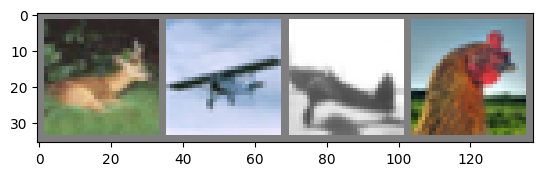

In [19]:
# dataset has PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset =  torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [20]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x))) # -> n, 6, 28, 28 (there is no padding) -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x))) # -> n, 16, 10, 10 -> n, 16, 5, 5
        x = x.view(-1, 16*5*5) # -> n, 400
        x = F.relu(self.fc1(x)) # -> n, 120
        x = F.relu(self.fc2(x)) # -> n, 84
        x =self.fc3(x) # -> n, 10
        return x
    
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
         # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)


Epoch [1/50], Step [2000/12500], Loss: 2.3425
Epoch [1/50], Step [4000/12500], Loss: 2.3265
Epoch [1/50], Step [6000/12500], Loss: 2.3095
Epoch [1/50], Step [8000/12500], Loss: 2.2967
Epoch [1/50], Step [10000/12500], Loss: 2.2904
Epoch [1/50], Step [12000/12500], Loss: 2.2589
Epoch [2/50], Step [2000/12500], Loss: 2.1820
Epoch [2/50], Step [4000/12500], Loss: 2.5401
Epoch [2/50], Step [6000/12500], Loss: 2.1028
Epoch [2/50], Step [8000/12500], Loss: 1.6195
Epoch [2/50], Step [10000/12500], Loss: 1.9922
Epoch [2/50], Step [12000/12500], Loss: 1.6127
Epoch [3/50], Step [2000/12500], Loss: 3.0463
Epoch [3/50], Step [4000/12500], Loss: 2.1894
Epoch [3/50], Step [6000/12500], Loss: 1.0491
Epoch [3/50], Step [8000/12500], Loss: 1.7621
Epoch [3/50], Step [10000/12500], Loss: 1.5867
Epoch [3/50], Step [12000/12500], Loss: 1.7709
Epoch [4/50], Step [2000/12500], Loss: 0.5404
Epoch [4/50], Step [4000/12500], Loss: 1.6882
Epoch [4/50], Step [6000/12500], Loss: 1.4624
Epoch [4/50], Step [8000/125

In [22]:
with torch.no_grad():
    n_samples = 0
    n_correct = 0
    n_samples_class = [0 for i in range(10)]
    n_correct_class = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if( label == pred):
                n_correct_class[label] += 1
            n_samples_class[label] += 1
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    
    for i in range(10):
        acc = 100.0 * n_correct_class[i] / n_samples_class[i]
        print(f'Accuracy of {classes[i]} : {acc} %')

Accuracy of the network: 64.48 %
Accuracy of plane : 71.0 %
Accuracy of car : 75.2 %
Accuracy of bird : 48.5 %
Accuracy of cat : 54.2 %
Accuracy of deer : 62.1 %
Accuracy of dog : 42.8 %
Accuracy of frog : 69.7 %
Accuracy of horse : 72.7 %
Accuracy of ship : 74.7 %
Accuracy of truck : 73.9 %
